**Importações**

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,roc_curve

**Analisando os dados**

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/credit_scoring/main/base_dados_traduzida.csv')
df.shape

(1000, 21)

In [4]:
df.head()

,default,conta_corrente,prazo_emprestimo_meses,historico_credito,proposito_emprestimo,valor_emprestimo,reserva_cc,tempo_emprego_atual,taxa_comp_salario,sexo_est_civil,outros_fiadores,anos_residencia_atual,propriedade,idade,outros_planos_financiamento,tipo_residencia,n_creditos_banco,status_emprego,n_dependentes,telefone,trabalhador_estrangeiro
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,none,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


In [5]:
df.dtypes

default                         int64
conta_corrente                 object
prazo_emprestimo_meses          int64
historico_credito              object
proposito_emprestimo           object
valor_emprestimo                int64
reserva_cc                     object
tempo_emprego_atual            object
taxa_comp_salario               int64
sexo_est_civil                 object
outros_fiadores                object
anos_residencia_atual           int64
propriedade                    object
idade                           int64
outros_planos_financiamento    object
tipo_residencia                object
n_creditos_banco                int64
status_emprego                 object
n_dependentes                   int64
telefone                       object
trabalhador_estrangeiro        object
dtype: object

In [6]:
for col in df.columns:
  print('Total de valores nulos na coluna {}: {}'.format(col,df[col].isnull().sum()))

Total de valores nulos na coluna default: 0
Total de valores nulos na coluna conta_corrente: 0
Total de valores nulos na coluna prazo_emprestimo_meses: 0
Total de valores nulos na coluna historico_credito: 0
Total de valores nulos na coluna proposito_emprestimo: 0
Total de valores nulos na coluna valor_emprestimo: 0
Total de valores nulos na coluna reserva_cc: 0
Total de valores nulos na coluna tempo_emprego_atual: 0
Total de valores nulos na coluna taxa_comp_salario: 0
Total de valores nulos na coluna sexo_est_civil: 0
Total de valores nulos na coluna outros_fiadores: 0
Total de valores nulos na coluna anos_residencia_atual: 0
Total de valores nulos na coluna propriedade: 0
Total de valores nulos na coluna idade: 0
Total de valores nulos na coluna outros_planos_financiamento: 0
Total de valores nulos na coluna tipo_residencia: 0
Total de valores nulos na coluna n_creditos_banco: 0
Total de valores nulos na coluna status_emprego: 0
Total de valores nulos na coluna n_dependentes: 0
Tota

In [7]:
duplicados = df.duplicated()
duplicados = duplicados.sum()
print('Total de números duplicados no dataset: {}'.format(duplicados))

Total de números duplicados no dataset: 0


**Análise gráfica das variáveis**

In [12]:
def histograma(col):
  plt.figure(figsize = (10,10))
  sns.countplot(x = col, data = df,  order = df[col].value_counts().index)
  plt.xlabel(col)
  plt.ylabel('Quantidade')
  plt.title('Distribuição ' + col)
  plt.show()


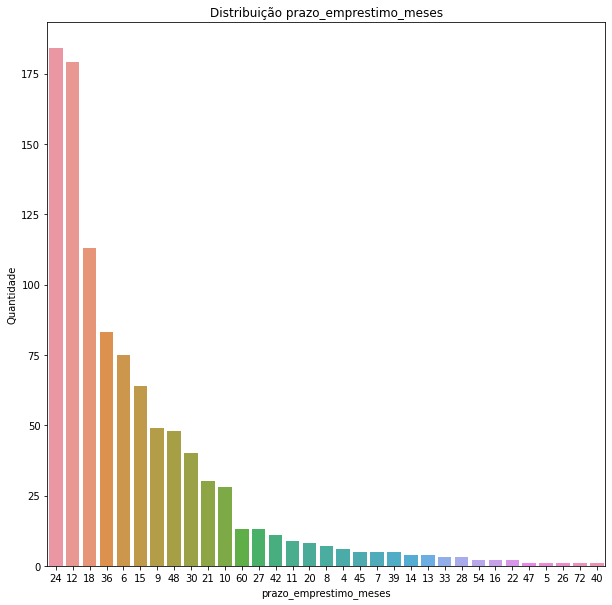

In [13]:
histograma('prazo_emprestimo_meses')

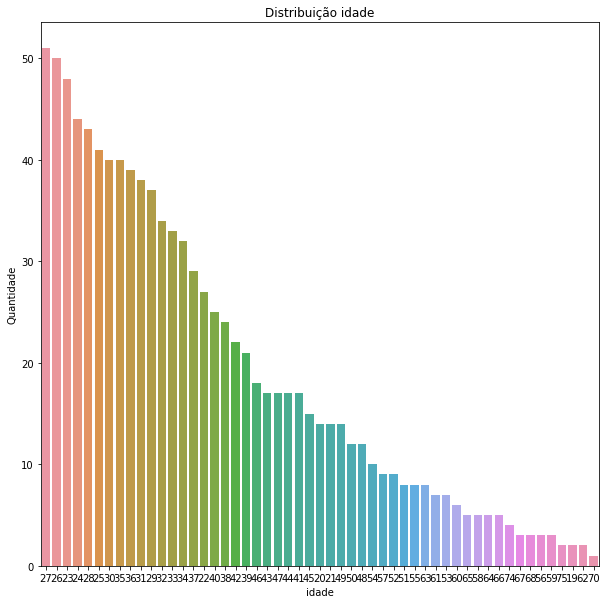

In [15]:
histograma('idade')

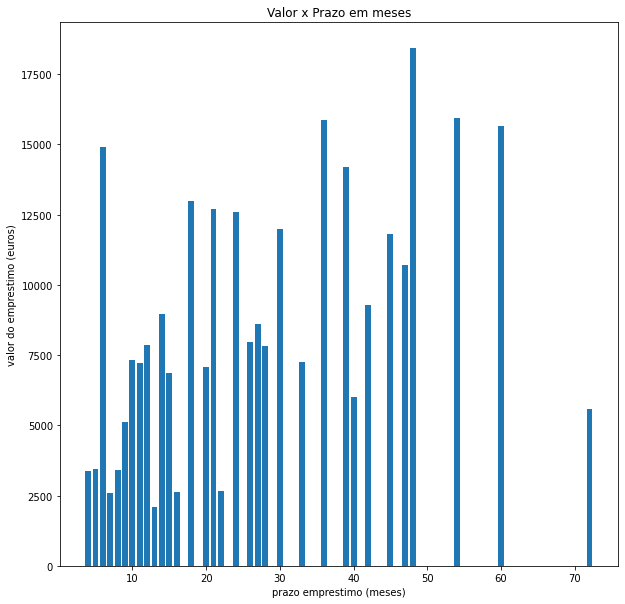

In [16]:
plt.figure(figsize = (10,10))
plt.bar(df['prazo_emprestimo_meses'],df['valor_emprestimo'])
plt.xlabel('prazo emprestimo (meses)')
plt.ylabel('valor do emprestimo (euros)')
plt.title('Valor x Prazo em meses')
plt.show()

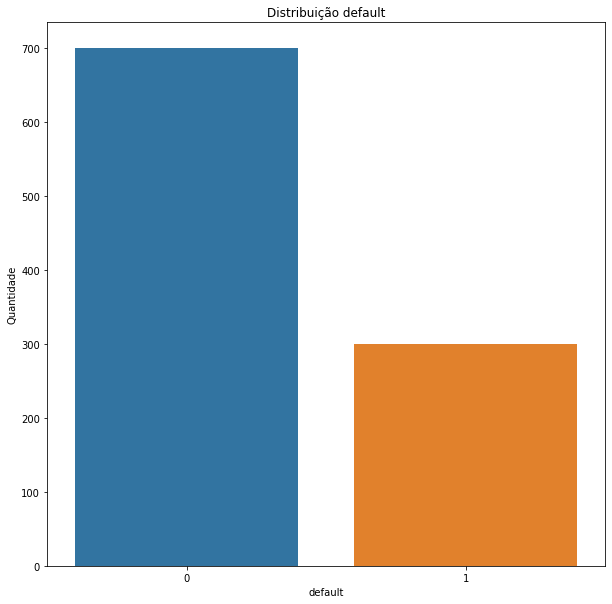

In [14]:
histograma('default')

Podemos perceber com a ajuda do histograma que a variável default é desbalanceada

**Criando faixas de classificação**

Com base nos gráficos acima podemos criar faixas de classificação para as variáveis idade,prazo de empréstimo e valor empréstimo

In [17]:
df['faixa_idade'] = pd.cut(x = df['idade'], bins = [18,30,40,50,60,70,80], labels = [1,2,3,4,5,6])

In [18]:
df['faixa_prazo_emprestimo'] = pd.cut(x = df['prazo_emprestimo_meses'], bins = [1,12,24,36,48,60,72], labels = [1,2,3,4,5,6])

In [19]:
df['faixa_valor_emprestimo'] = pd.cut(x = df['valor_emprestimo'], bins = [x  for x in range(0,21000,1000) ], labels = [x  for x in range(1,21,1) ])

Removendo as variáveis utilizadas nas faixas de classificação, e a variável sexo_est_civil por ser uma informação sensível

In [20]:
info_drop = ['sexo_est_civil','idade','prazo_emprestimo_meses','valor_emprestimo']
df.drop(columns = info_drop, inplace = True)

**Transformando as variáveis do tipo object em númericas usando Label Encoder**

In [22]:
vars_quali = df.dtypes[df.dtypes == object].keys()
for col in vars_quali:
  label_encoder = LabelEncoder()
  strings = list(df[col].values.astype('str'))
  label_encoder.fit(strings)
  df[col] = label_encoder.transform(strings)

In [23]:
df.head()

,default,conta_corrente,historico_credito,proposito_emprestimo,reserva_cc,tempo_emprego_atual,taxa_comp_salario,outros_fiadores,anos_residencia_atual,propriedade,outros_planos_financiamento,tipo_residencia,n_creditos_banco,status_emprego,n_dependentes,telefone,trabalhador_estrangeiro,faixa_idade,faixa_prazo_emprestimo,faixa_valor_emprestimo
0,0,1,1,4,4,0,4,2,4,2,1,1,2,1,1,1,1,5,1,2
1,1,0,3,4,1,2,2,2,2,2,1,1,1,1,1,0,1,1,4,6
2,0,3,1,0,1,3,2,2,3,2,1,1,1,3,2,0,1,3,1,3
3,0,1,3,7,1,3,2,1,4,0,1,0,1,1,2,0,1,3,4,8
4,1,1,2,2,1,2,3,2,4,3,1,0,2,1,2,0,1,4,2,5


**Criando o modelo de regressão logística**

In [25]:
def my_model(dataset,classifier, kbest = False):
  y = dataset['default']
  X = dataset.drop(columns = 'default')
  seed = 25
  X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = seed)
  
  if kbest:
    selectkbest = SelectKBest(chi2, k = 5)
    selectkbest.fit(X_train,y_train)
    X_train = selectkbest.transform(X_train)
    X_test = selectkbest.transform(X_test)
  
  model = classifier
  model.fit(X_train,y_train)

  matriz = plot_confusion_matrix(model,X_train,y_train, values_format = '.3g',cmap = 'Blues')
  plt.title('Matrix de confusão')
  plt.show()

  predict = model.predict(X_test)
  print('\n Classification Report:')
  print(classification_report(y_test,predict))

  prob_predict = model.predict_proba(X_test)[:,1]
  tfp,tvp,limite = roc_curve(y_test,prob_predict)
  print('roc_auc:',roc_auc_score(y_test,prob_predict))

  plt.subplots(1,figsize = (5,5))
  plt.title('Curva roc')
  plt.plot(tfp,tvp)
  plt.xlabel('Especificidade')
  plt.ylabel('Sensibilidade')
  plt.plot([0,1], ls = '--',c = 'red')
  plt.plot([0,0],[0,1], ls = '--',c = 'green'),plt.plot([1,1], ls = '--', c = 'green')
  plt.show()

  return model,matriz


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


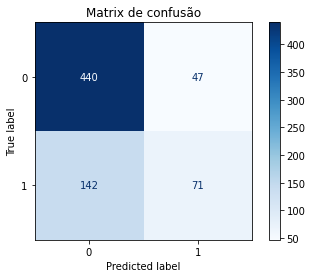


 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       213
           1       0.51      0.33      0.40        87

    accuracy                           0.71       300
   macro avg       0.64      0.60      0.61       300
weighted avg       0.69      0.71      0.69       300

roc_auc: 0.7287248394582052


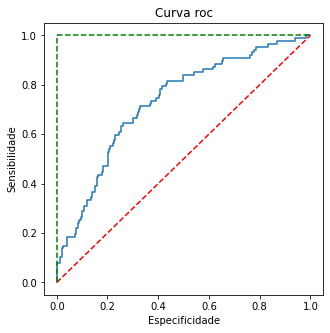

In [27]:
lg = my_model(df,LogisticRegression(max_iter=1000))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


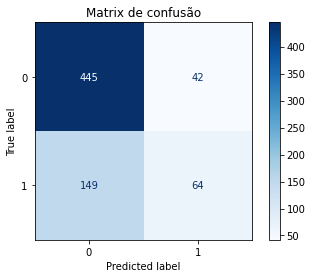


 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       213
           1       0.46      0.29      0.35        87

    accuracy                           0.70       300
   macro avg       0.61      0.58      0.58       300
weighted avg       0.67      0.70      0.67       300

roc_auc: 0.7177162592412712


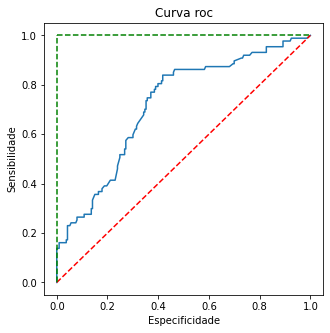

In [28]:
lg_kbest = my_model(df,LogisticRegression(max_iter=1000), kbest= True)

**Modelo Decision Tree**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


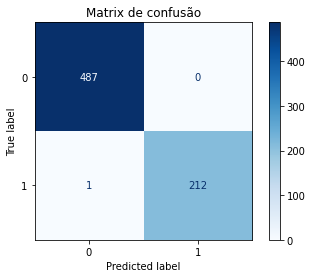


 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       213
           1       0.41      0.37      0.39        87

    accuracy                           0.66       300
   macro avg       0.58      0.57      0.58       300
weighted avg       0.65      0.66      0.65       300

roc_auc: 0.5720954076952134


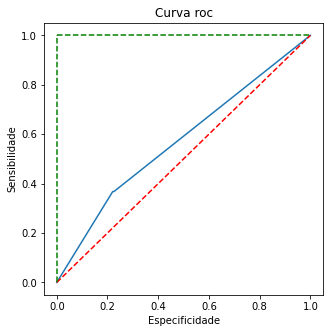

In [32]:
dt = my_model(df,DecisionTreeClassifier(random_state = 25))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


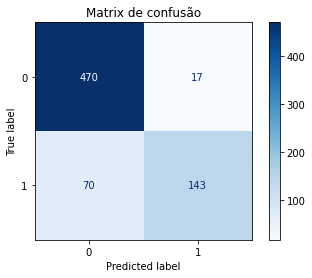


 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       213
           1       0.51      0.39      0.44        87

    accuracy                           0.71       300
   macro avg       0.64      0.62      0.62       300
weighted avg       0.70      0.71      0.70       300

roc_auc: 0.6490475419567212


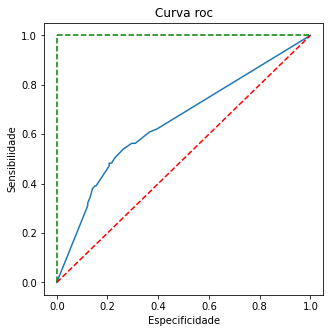

In [33]:
dt_kbest = my_model(df,DecisionTreeClassifier(random_state = 25), kbest= True)

**Conclusões**



*   Em razão do dataset ter a variável resposta desbalanceada (existem muitos mais casos de reprovação do que aprovação) a acurácia do modelo não é uma boa métrica para esse caso
*   Na redução de dimensionalidade usando o SelectKBest houve uma redução na precisão, porém o modelo requer uma quantidade menor de dados
*   O modelo de Logistic Regression se mostrou superior ao Decision Tree Classifier
*   Mesmo com a remoção de informações sensíveis o modelo conseguiu um desempenho satisfatório











